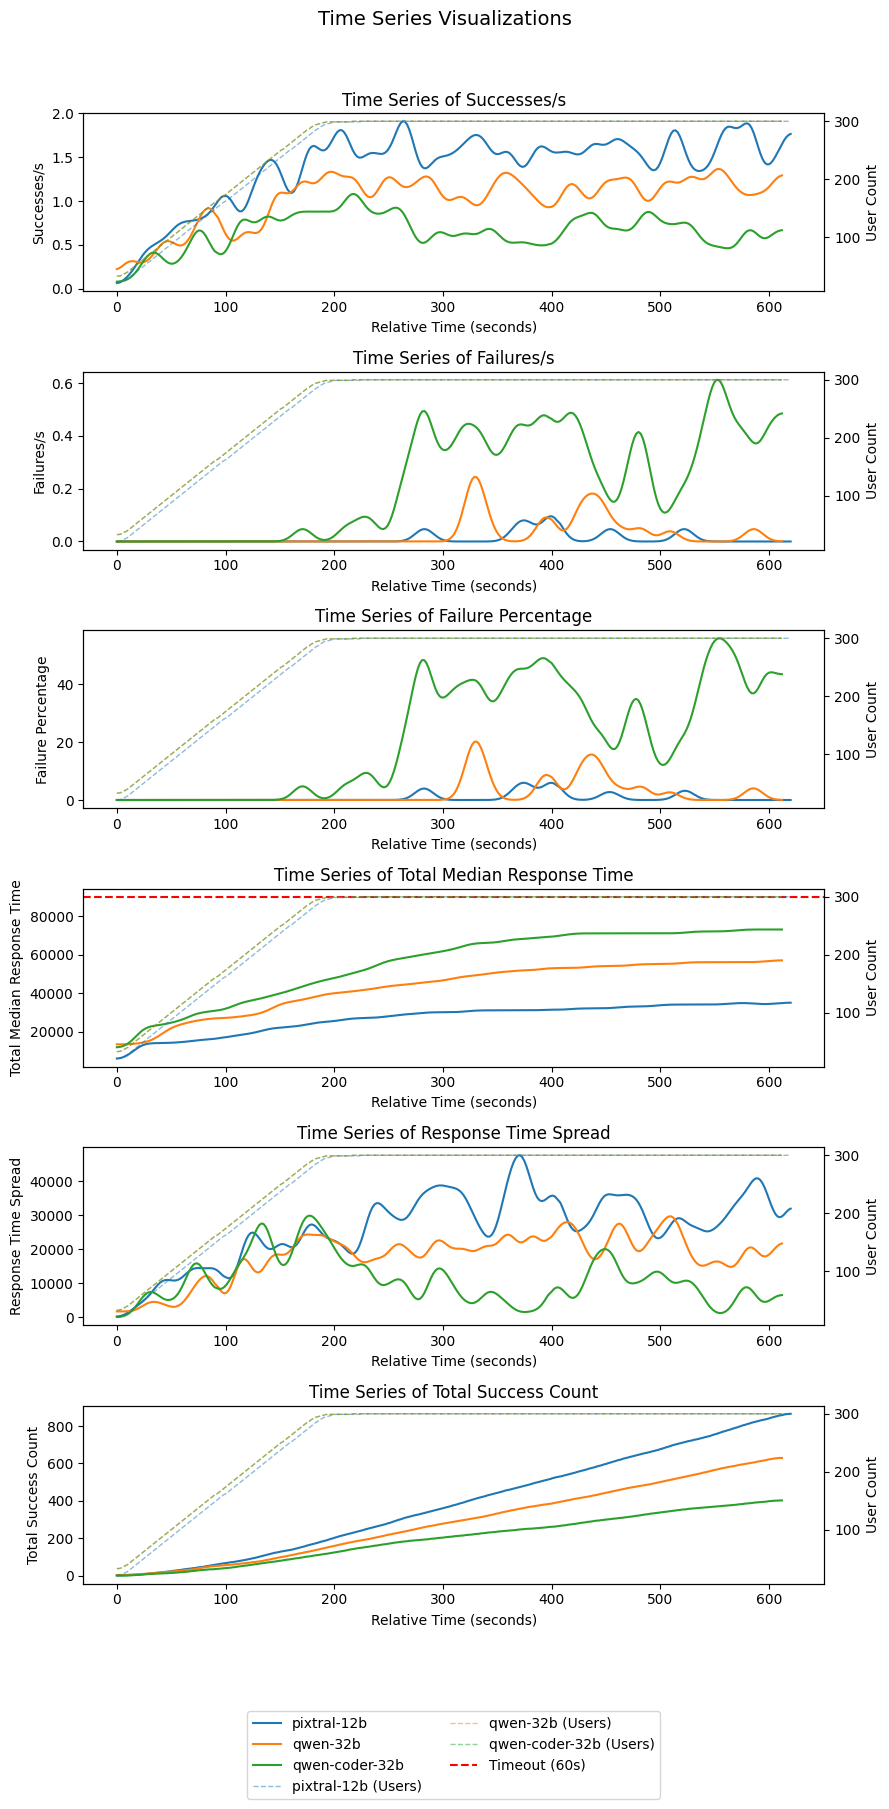

In [199]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.ndimage import gaussian_filter1d

# Load CSV file
def load_data(file_path):
    # 'Timestamp', 'User Count', 'Type', 'Name', 'Requests/s', 'Failures/s', '50%', '66%', '75%', '80%', '90%', '95%', '98%', '99%', '99.9%', '99.99%', '100%', 'Total Request Count', 'Total Failure Count', 'Total Median Response Time', 'Total Average Response Time', 'Total Min Response Time', 'Total Max Response Time', 'Total Average Content Size', 'Successes/s', 'Total Success Count'
    df = pd.read_csv(file_path)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
    df.sort_values(by='Timestamp', inplace=True)
    df = df[df["Name"] != "Aggregated"]
    df["Successes/s"] = df["Requests/s"] - df["Failures/s"]
    df["Total Success Count"] = df["Total Request Count"] - df["Total Failure Count"]
    df['Failure Percentage'] = ((df['Failures/s'] / df['Requests/s']) * 100).fillna(0.0)
    df['Response Time Spread'] = df['95%'] - df['50%']
    return df

# Adjust timestamps to start each group at zero
def adjust_start_times(df):
    df = df.copy()
    start_times = df.groupby('Name')['Timestamp'].min()
    df['Relative Timestamp'] = df.apply(lambda row: (row['Timestamp'] - start_times[row['Name']]).total_seconds(), axis=1)
    return df

# Plot time-series data grouped by 'Name' with smoothing and user count on secondary axis
def plot_time_series(df, column, title, ax1, ax2):
    for name, group in df.groupby('Name'):
        smoothed_values = gaussian_filter1d(group[column], sigma=4)  # Apply smoothing
        ax1.plot(group['Relative Timestamp'], smoothed_values, label=name)
        
        # Plot User Count with dashed line
        smoothed_users = gaussian_filter1d(group['User Count'], sigma=4)
        ax2.plot(group['Relative Timestamp'], smoothed_users, linestyle='--', lw=1, alpha=0.5, label=f"{name} (Users)")
    
    if "Response Time" in column and "Spread" not in column:
        ax1.axhline(y=90000, color='r', linestyle='--', label='Timeout (60s)')
    
    ax1.set_title(title, fontsize=12)
    ax1.set_xlabel('Relative Time (seconds)', fontsize=10)
    ax1.set_ylabel(column, fontsize=10)
    ax2.set_ylabel('User Count', fontsize=10)
    
    return ax1, ax2

# Main function to visualize data
def visualize(file_path):
    df = load_data(file_path)
    df = adjust_start_times(df)
    
    # Attributes to visualize
    attributes = ['Successes/s', 'Failures/s', 
                  'Failure Percentage',
                  'Total Median Response Time', 'Response Time Spread',
                  'Total Success Count']
    
    # Create figure with subplots
    fig, axes = plt.subplots(len(attributes), 1, figsize=(9, 16))
    fig.suptitle('Time Series Visualizations', fontsize=14, y=1.02)
    
    # Collect legend handles and labels
    handles = []
    labels = []
    
    for idx, attr in enumerate(attributes):
        ax1 = axes[idx]
        ax2 = ax1.twinx()
        
        # Plot the data
        ax1, ax2 = plot_time_series(df, attr, f'Time Series of {attr}', ax1, ax2)
        
        # Collect legend handles and labels
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        handles.extend(lines1 + lines2)
        labels.extend(labels1 + labels2)
        
        # Adjust layout for each subplot
        plt.tight_layout()
    
    # Remove duplicate handles and labels
    unique_handles = []
    unique_labels = []
    seen = set()
    for h, l in zip(handles, labels):
        if l not in seen:
            unique_handles.append(h)
            unique_labels.append(l)
            seen.add(l)
    
    # Add a single legend at the bottom
    plt.legend(unique_handles, unique_labels, 
               loc='lower center', 
               bbox_to_anchor=(0.5, -1.25),
               ncol=2)
    
    # Set x-axis labels for the bottom plot
    axes[-1].set_xlabel('Relative Time (seconds)', fontsize=10)
    
    plt.show()

# Example usage
visualize('./export/chat_stats_history.csv')

https://lmcache.ai/kv_cache_calculator.html

In [153]:
import json

def parse_hf_config(config_dict):
    """
    Extracts relevant values from a Hugging Face model config dictionary
    and calculates memory usage per token.
    """
    # Extract relevant values
    hidden_size = config_dict.get("hidden_size", 0)
    num_hidden_layers = config_dict.get("num_hidden_layers", 0)
    num_attention_heads = config_dict.get("num_attention_heads", 0)
    num_key_value_heads = config_dict.get("num_key_value_heads", num_attention_heads)  # Default to attn heads if not specified
    torch_dtype = config_dict.get("torch_dtype", "float16")
    
    # Determine bytes per element (FP16/BF16 = 2 bytes, FP32 = 4 bytes)
    dtype_size = 2 if "16" in torch_dtype else 4
    
    # KV cache memory per token (Approximation)
    kv_cache_per_token = 2 * num_hidden_layers * num_key_value_heads * (hidden_size // num_attention_heads) * dtype_size  # in bytes
    
    # Convert to KB for readability
    kv_cache_per_token_kb = kv_cache_per_token / 1024
    
    return {
        "hidden_size": hidden_size,
        "num_hidden_layers": num_hidden_layers,
        "num_attention_heads": num_attention_heads,
        "num_key_value_heads": num_key_value_heads,
        "dtype": torch_dtype,
        "kv_cache_per_token_kb": kv_cache_per_token_kb
    }

# Example usage
config_json = """
{
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 5120,
  "initializer_range": 0.02,
  "intermediate_size": 27648,
  "max_position_embeddings": 32768,
  "max_window_layers": 70,
  "model_type": "qwen2",
  "num_attention_heads": 40,
  "num_hidden_layers": 64,
  "num_key_value_heads": 8,
  "rms_norm_eps": 1e-06,
  "rope_theta": 1000000.0,
  "sliding_window": 131072,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.43.1",
  "use_cache": true,
  "use_sliding_window": false,
  "vocab_size": 152064
}
"""

config_dict = json.loads(config_json)
parsed_values = parse_hf_config(config_dict)

print("Relevant values:")
for key, value in parsed_values.items():
    print(f"{key}: {value}")


Relevant values:
hidden_size: 5120
num_hidden_layers: 64
num_attention_heads: 40
num_key_value_heads: 8
dtype: bfloat16
kv_cache_per_token_kb: 256.0


# vLLM Benchmarks

In [1]:
csv_file = "export/export.csv"
import pandas as pd
df = pd.read_csv(csv_file, sep="\t")
df = df.iloc[:, [0,1,2,3,4,5,6,7,8,9]]
df["VRAM"] = df["VRAM"].str.replace("GB", "").astype(float)
df["out tok/s"] = df["out tok/s"].str.replace(" tok/s", "").astype(float)
df["total tok/s"] = df["total tok/s"].str.replace(" tok/s", "").astype(float)
df["requests/s"] = df["requests/s"].str.replace(" req/s", "").astype(float)
df["nGPU"] = df["GPU"].apply(lambda x: x[0]).astype(float)
df = df.iloc[:-1,:]
df.set_index("Model", inplace=True)
df = df.rename(columns={df.columns[3]: "FP32"})
df

,Model Params (in B),GPU,VRAM,FP32,out tok/s,total tok/s,requests/s,TP,PP,nGPU
Model,,,,,,,,,,
qwen-32b,32.0,2xA40,96.0,149.6,691.0,1515.0,3.54,2.0,1.0,2.0
qwen-32b,32.0,4xA40,192.0,299.2,756.0,1658.0,3.87,4.0,1.0,4.0
Llama 3.1 70B,70.0,1xGH200,96.0,494.0,1022.0,2393.0,5.90,1.0,1.0,1.0
Llama 3.1 70B,70.0,1xMI300X,192.0,653.7,1294.0,2510.0,6.26,1.0,1.0,1.0
Llama 3.1 70B,70.0,8xL4,192.0,480.0,307.0,717.0,1.76,2.0,4.0,8.0
Llama 3.1 70B,70.0,8xL4,192.0,480.0,261.0,610.0,1.50,4.0,2.0,8.0
Llama 3.1 405B,405.0,8xMI300X,1536.0,5229.6,1148.0,2843.0,7.29,1.0,1.0,8.0
Llama 3.2 11B Vision Instruct,11.0,1xL4,24.0,60.0,285.0,623.0,1.47,1.0,1.0,1.0


In [6]:
import statsmodels.api as sm

X = df.iloc[:,[0,2,3]]
# X = sm.add_constant(X)
y = df.iloc[:, 4]

X

,Model Params (in B),VRAM,FP32
Model,,,
qwen-32b,32.0,96.0,149.6
qwen-32b,32.0,192.0,299.2
Llama 3.1 70B,70.0,96.0,494.0
Llama 3.1 70B,70.0,192.0,653.7
Llama 3.1 70B,70.0,192.0,480.0
Llama 3.1 70B,70.0,192.0,480.0
Llama 3.1 405B,405.0,1536.0,5229.6
Llama 3.2 11B Vision Instruct,11.0,24.0,60.0


In [7]:
model = sm.OLS(y, X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:              out tok/s   R-squared (uncentered):                   0.726
Model:                            OLS   Adj. R-squared (uncentered):              0.562
Method:                 Least Squares   F-statistic:                              4.422
Date:                Fri, 14 Mar 2025   Prob (F-statistic):                      0.0716
Time:                        15:15:48   Log-Likelihood:                         -59.806
No. Observations:                   8   AIC:                                      125.6
Df Residuals:                       5   BIC:                                      125.9
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

/Users/matthiasmatt/miniconda3/envs/torch/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [8]:
new_X = df.iloc[:,[0,2,3]]
# new_X = sm.add_constant(new_X)  # Add constant term
prediction = model.predict(new_X)
prediction

Model
qwen-32b                          457.361587
qwen-32b                          262.828368
Llama 3.1 70B                     754.595954
Llama 3.1 70B                     546.077264
Llama 3.1 70B                     786.599672
Llama 3.1 70B                     786.599672
Llama 3.1 405B                   1211.002636
Llama 3.2 11B Vision Instruct     144.161313
dtype: float64

In [10]:
def predict_performance(n_params: float, vram: float, fp32: float):
    X = pd.DataFrame({"Model Params (in B)": [n_params], "VRAM": [vram], "FP32": [fp32]})
    return model.predict(X)

predict_performance(n_params=32., vram=96., fp32=150.)

0    456.807707
dtype: float64

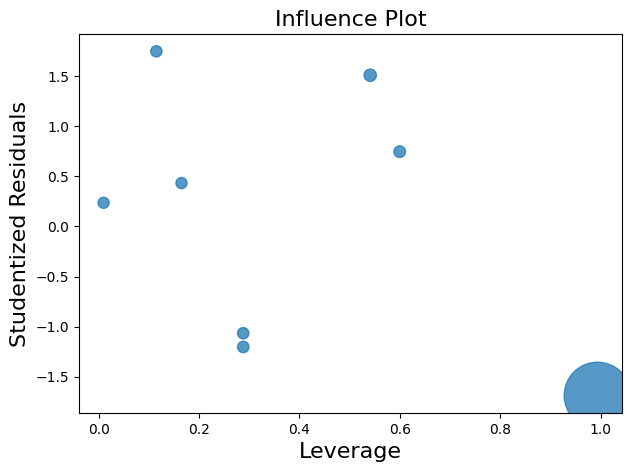

In [11]:
fig = sm.graphics.influence_plot(model, criterion="cooks")
fig.tight_layout(pad=1.0)

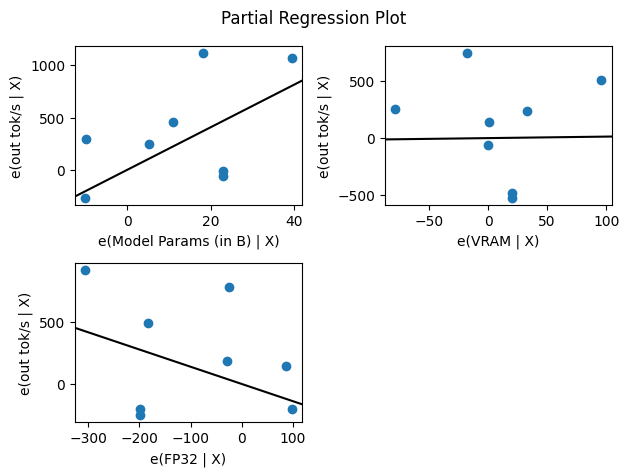

In [12]:
fig = sm.graphics.plot_partregress_grid(model)
fig.tight_layout(pad=1.0)

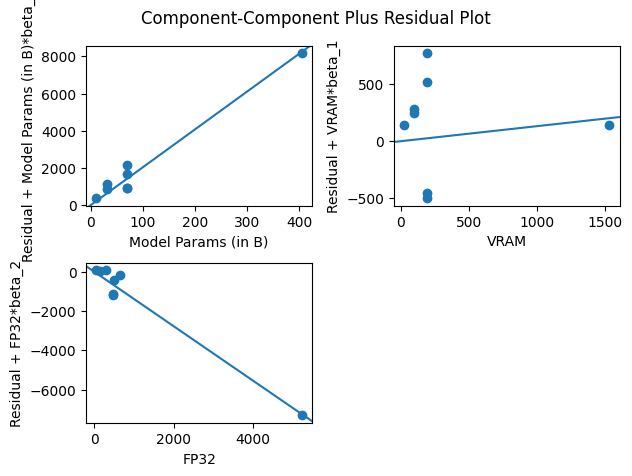

In [13]:
fig = sm.graphics.plot_ccpr_grid(model)
fig.tight_layout(pad=1.0)